<a href="https://colab.research.google.com/github/Safa06/Thesis/blob/main/KSC(100epoch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
# VGG16
#import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import scipy.io
from scipy.io import loadmat
#from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint

# **Data Load**

In [2]:
# DATA load
mat_data1= scipy.io.loadmat('/content/drive/MyDrive/Thdata/KSC_corrected.mat')
mat_data2=scipy.io.loadmat('/content/drive/MyDrive/Thdata/KSC_gt.mat')
X=mat_data1['KSC']
y=mat_data2['KSC_gt']
print(X.shape)
print(y.shape)


(512, 614, 176)
(512, 614)


# **Apply PCA,Padding**

In [3]:
# Apply PCA to minimize band from 200 to 3 band
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

K = 3
X,pca= applyPCA(X,numComponents=K)
print(X.shape, y.shape)



#padding with zero
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


(512, 614, 3) (512, 614)


# **Create Patches**

In [4]:
# Window for patches
windowSize=23
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

X, y = createImageCubes(X, y, windowSize=windowSize)
#print(X.shape,y.shape)

# **Train-test split**

In [5]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3647, 23, 23, 3) (1564, 23, 23, 3) (3647,) (1564,)


# **Model**

In [6]:

S = windowSize
L = K
#output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

## input layer
input_layer = (23,23,3)

#for 3D CNN--input_layer=Input(S, S, L, 1)

#Model
model = Sequential()

#Block 1

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same",input_shape=(23,23,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(MaxPooling2D((1, 1), strides=(1, 1)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=13, activation='softmax'))

model.build()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                   

# **Epoch starts**

In [7]:
# checkpoint for saving epochs
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),batch_size=64,callbacks=callbacks_list)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 2.3015 - accuracy: 0.1796
Epoch 1: accuracy improved from -inf to 0.17960, saving model to best-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 16s 97ms/step - loss: 2.3015 - accuracy: 0.1796 - val_loss: 1.9412 - val_accuracy: 0.3414
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 1.8321 - accuracy: 0.3219
Epoch 2: accuracy improved from 0.17960 to 0.32191, saving model to best-model.hdf5
57/57 [==============================] - 4s 65ms/step - loss: 1.8321 - accuracy: 0.3219 - val_loss: 1.6787 - val_accuracy: 0.3414
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 1.6177 - accuracy: 0.3927
Epoch 3: accuracy improved from 0.32191 to 0.39265, saving model to best-model.hdf5
57/57 [==============================] - 10s 171ms/step - loss: 1.6177 - accuracy: 0.3927 - val_loss: 1.7241 - val_accuracy: 0.3421
Epoch 4/100
56/57 [============================>.] - ETA: 0s - loss: 1.4654 - accuracy: 0.4188
Epoch 4: accuracy improved from 0.39265 to 0.42117, saving model to best-model.hdf5
57/57 [==============================] - 4s 63ms/step - loss: 1.4601 -

# **Graph**

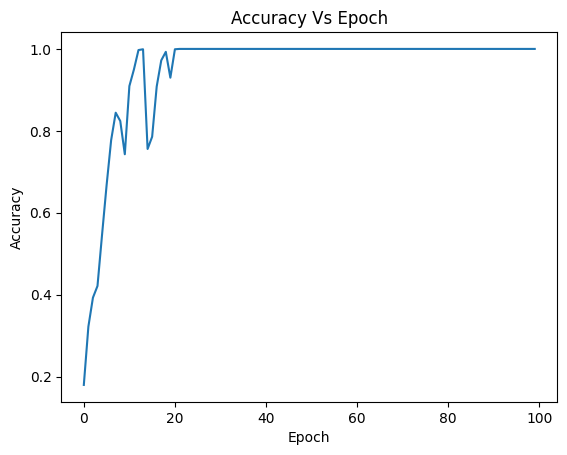

<Figure size 640x480 with 0 Axes>

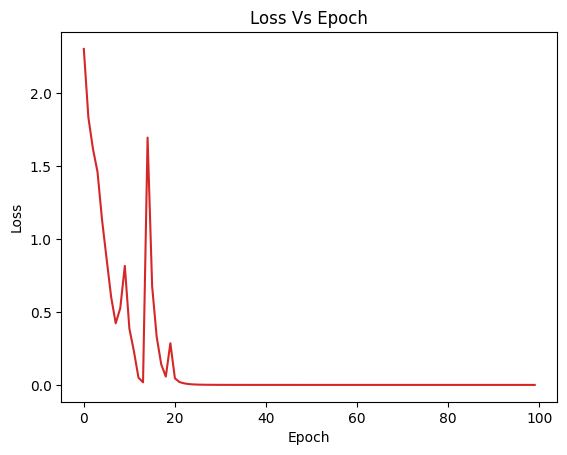

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure()
plt.plot(history.history['accuracy'],color ='tab:blue')
plt.title('Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy_Vs-Epoch.png',dpi=300)

plt.figure()
plt.plot(history.history['loss'],color ='tab:red')
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss_Vs-Epoch.png',dpi=300)

# **Testing & Confusion Matrix**

49/49 - 1s - loss: 5.0784e-05 - accuracy: 1.0000 - 879ms/epoch - 18ms/step
49/49 [==============================] - 0s 5ms/step
(1564,) (1564, 13) (1564,)
[[246   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  65   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  82   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  47   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  74   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 127   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 146   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 127   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 110   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 160   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 288]]


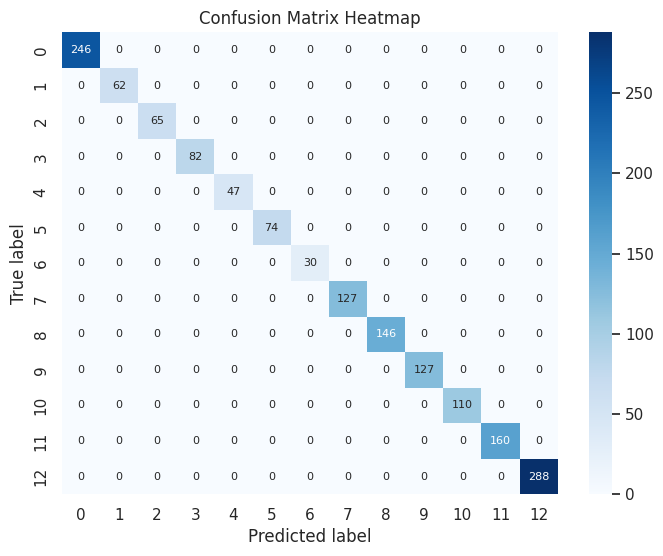

<Figure size 640x480 with 0 Axes>

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
print(y_test.shape,y_pred.shape,y_pred_classes.shape)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print(conf_matrix)


#Confusion matrix heatmap

plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Adjust font scale if needed
sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={"size": 8}, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('Conf_matrix_heatmap.png',dpi=300)

# **Precision, Recall, F1 Score**

In [10]:
# precision = precision_score(y_test,y_pred_classes)
# recall = recall_score(y_test,y_pred_classes)
# f1 = f1_score(y_test,y_pred_classes)

# print('Classification Report')
# print("Precision: ",precision)
# print("Recall: ",recall)
# print("F1 Score: ",f1)

report = classification_report(y_test,y_pred_classes)
print(report)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       246
         1.0       1.00      1.00      1.00        62
         2.0       1.00      1.00      1.00        65
         3.0       1.00      1.00      1.00        82
         4.0       1.00      1.00      1.00        47
         5.0       1.00      1.00      1.00        74
         6.0       1.00      1.00      1.00        30
         7.0       1.00      1.00      1.00       127
         8.0       1.00      1.00      1.00       146
         9.0       1.00      1.00      1.00       127
        10.0       1.00      1.00      1.00       110
        11.0       1.00      1.00      1.00       160
        12.0       1.00      1.00      1.00       288

    accuracy                           1.00      1564
   macro avg       1.00      1.00      1.00      1564
weighted avg       1.00      1.00      1.00      1564



# **Classification report shows**

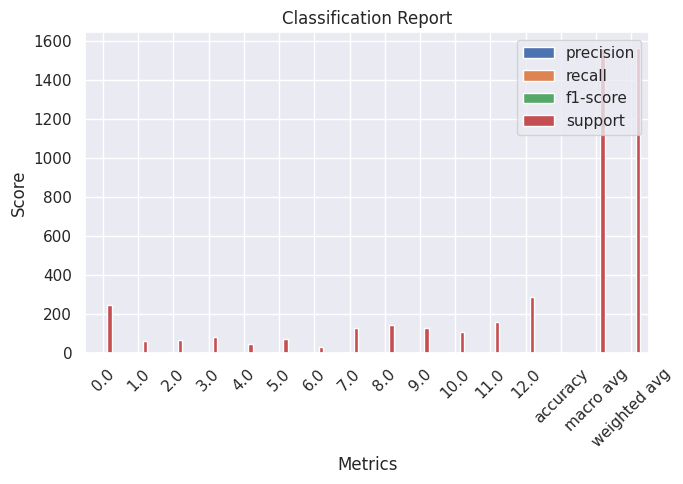

In [11]:
report = classification_report(y_test, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
fig, ax = plt.subplots(figsize=(7, 5))
report_df.plot(kind='bar', ax=ax)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
# Access precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

Precision per class: 1.0
Recall per class: 1.0
F1 Score per class: 1.0
